---

## 单变量模拟 | Univariate Simulation


### 动机 | Motivation

Financial option pricing
- **The fair-value price of European option** on an underlying $S = (S_t)_{0 \leqslant T}$ with final payoff $f(S_T)$ at time $T$ can be represented mathematically as:

$$
\mathbb{E}[f(S_T)]
$$

> For simplicity, the interest rates are assumed to be zero.
> The **hedging strategy** should be factored in the price of the option.

- $S_T$ - A random variable
- The distribution of $S_T$ depends on the model chosen for the process $S$.

> For most models, it is not possible to compute $\mathbb{E}f(S_T)$ exactly, so numerical approximations are needed.

In the previous chapter, we used the Feynman-Kac formula to write this expectation as the solution of a **PDE**, and proposed **finite-different schemes** to solve the PDE.<br>
In the next few chapters, we use an alternative numerical approximation called **Monte Carlo Method, 蒙特卡洛方法**.

The idea is to approximate $\mathbb{E}[f(S_T)]$ by the **Empirical Average, 经验平均**:

$$
\frac1M \sum_{m = 1}^{M} f(S_T^m)
$$
- $S_T^1, ..., S_T^M$ are independent and identically distributed (iid, 独立同分布) simulations of the random variable $S_T$

---

蒙特卡洛方法的理论依据：
- 根据 **大数定律**，当模拟次数 `M` 足够大时，这个经验平均值会非常接近真实的数学期望值。
- 样本必须是独立同分布的，以保证收敛的有效性和稳定性。

---

## 1. 均匀随机变量的模拟 | Simulation of Uniform random variables


### 1.1 模拟随机数 | Simulating random numbers

- **Genuine, 真** random numbers can only be produced by physical and real-world processes.

- Random numbers from software might look genuinely random at first glance, yet they do come from a deterministic algorithm.
    - Therefore, they are called **psedorandom numbers, 伪随机数**.
    - Main advantages:
        1. Can be reproduced (which facilitates controlled and replicable experiments)
        2. Can accommodate any type of distribution and properties
    > 可重现，有助于进行可控和可复现的实验<br>
    > 可以适应任何类型的分布和属性

- **Quasirandom numbers, 拟随机数** are constructed to maximize some goodness-of-fit measure, 最大化某种拟合优度度量 (low discrepancy, 低差异性). 
    - They look too "perfect" to be random, but satisfy relevant theoretical properties as well. 
    - They are popular for numerical integration.

- **Bootstrap methods** resample from a given dataset. 
    - Their advantage is that no parametric distribution assumptions are required (model-free simulation) but they do require a representative set of available observations.
    > 从给定的数据集中进行重复抽样<br>
    > 不需要参数化的分布假设<br>
    > 无模型模拟

---

### 1.2 均匀分布 | Uniform distribution

A uniform random variable $U \sim \text{Uniform}(0, 1)$ 

$$
\mathbb{P}(a \leqslant U \leqslant b) = b - a
$$
- $\forall \, 0 \leqslant a \leqslant b \leqslant 1$


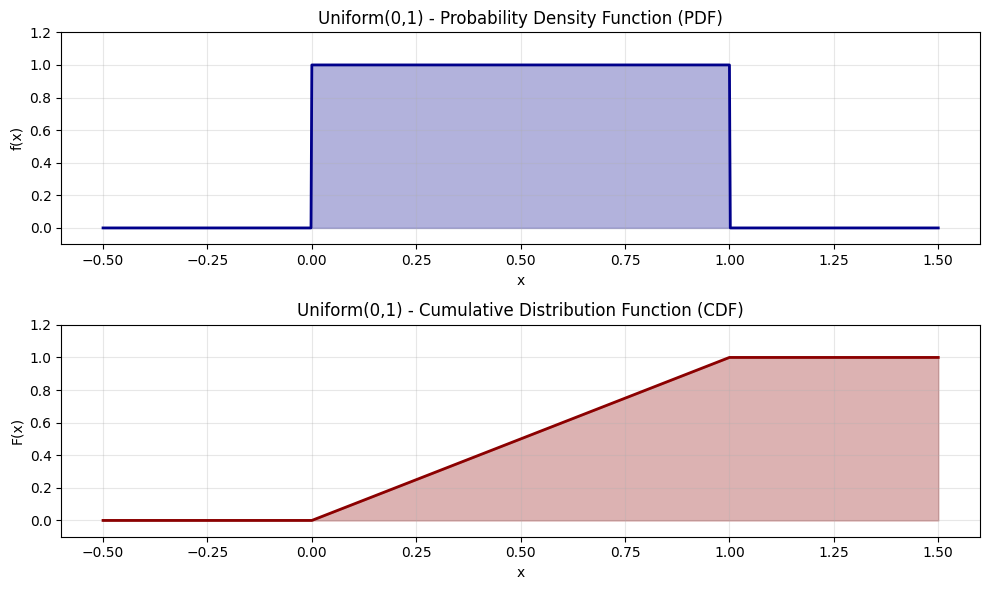

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform

def plot_uniform_pdf_cdf():
    x = np.linspace(-0.5, 1.5, 1001)

    pdf = uniform.pdf(x, loc = 0, scale = 1)    # loc=下界，scale=区间长度（1-0=1）
    cdf = uniform.cdf(x, loc = 0, scale = 1)
    
    plt.figure(figsize=(10, 6))

    # PDF
    plt.subplot(2, 1, 1)  # 2行1列，第1个子图
    plt.plot(x, pdf, color='darkblue', linewidth=2)
    plt.fill_between(x, pdf, alpha=0.3, color='darkblue')  # 填充PDF下方区域
    plt.title('Uniform(0,1) - Probability Density Function (PDF)', fontsize=12)
    plt.xlabel('x', fontsize=10)
    plt.ylabel('f(x)', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.1, 1.2)  # y轴范围（避免图形过扁）

    # CDF
    plt.subplot(2, 1, 2)  # 2行1列，第2个子图
    plt.plot(x, cdf, color='darkred', linewidth=2)
    plt.fill_between(x, cdf, alpha=0.3, color='darkred')  # 填充CDF下方区域
    plt.title('Uniform(0,1) - Cumulative Distribution Function (CDF)', fontsize=12)
    plt.xlabel('x', fontsize=10)
    plt.ylabel('F(x)', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.1, 1.2)  # y轴范围

    plt.tight_layout()  # 自动调整子图间距，避免标题重叠
    plt.show()

plot_uniform_pdf_cdf()

---

### 1.3 序列同余生成器 | Sequential Congruential Generators

A simple algorithm to generate a sequence of integers is the **Linear Congruential Generator, 线性同余生成器**:

$$
n_i = (a n_{i-1} + c)\mod m
$$
- $n_0, a, c, m \in \Z$ 

This method produces value $n_i \in \{ 0, ..., m - 1 \}$.

To produce values in $[0, 1)$:
$$
u_i := \frac{n_i}{m}
$$


---

#### 线性同余生成器 | Linear Congruential Generators

Linear congruential generators generate **periodic sequences, 周期性序列**. 

Since the parameters $a, c, m$ are fixed, a certain realization $n_{i-1}$ will always be followed by the same successor $n_i$.

At best, the periodic sequence can contain $m$ unique numbers. 
> 在最好的情况下，该周期序列可以包含 $m$ 个唯一的数字。

For inappropriate choices for the values of $a, c$, the sequence could be much shorter as some integers within the range would never be drawn.

As a result, the statistical properties of congruential generators (can the $u_i$ be distinguished from a true uniform random variable?) depend on the choice of $a, c$, and the larger  the better as it increases the maximum length of the periodic sequence.

---

特性：
- 周期性（主要缺点）
- 参数选择极其重要（失败案例：IBM的RANDU - 糟糕的参数选择而导致模拟结果严重失真）

优点：
- 实现简单、计算速度快。

缺点：
- 周期长度和统计性质难以满足现代要求

---

##### 梅森旋转算法 | Mersenne Twister

为了解决传统 LCG 的诸多缺陷而开发的更先进的生成器。

核心改进：
- 极长周期，通常是一个梅森素数（$2^{19937} - 1$）
- 高维均匀性


---

#### 置换同余生成器 | Permuted congruential generators, PCG

This improve upon linear congruential generators (LCG) by permuting the state of the generator before producing one output.
> PCG 通过在生产输出之前对生成器的状态进行**置换**，从而改进了线性同余生成器。

In addition, the output contains fewer bits than the generator state, which makes the resulting sequence less predictable.

PCG is a parametric class of random number generators
> PCG 是一个参数化的随机数生成器类别。

> PCGs are the new state-of-the-art in uniform random number generation, and are now the new default random number generator in NumPy.

---

PCG 家族代表了 LCG 的现代化演进。

它的核心思想是：“LCG 的内部状态其实很不错，但它的直接输出不够好。”

核心改进机制：
- 状态置换：
    - PCG 使用 LCG 来维护一个高质量的内部状态。
    - 但在输出之前，它不会直接输出这个状态，而是对一个“输出函数”（通常是一个比特位置换、移位或与一个随机常数进行异或操作）应用到这个状态上。
    - 这个步骤打乱了状态的比特模式，极大地改善了输出序列的随机性。
- 输出缩减：
    - PCG 通常只输出状态的一部分比特。
    - 这使得从输出序列反向推导出完整的内部状态变得非常困难，从而增强了生成器的不可预测性。

优点：
- 继承了 LCG 的简单、快速、节省内存的优点。
- 通过置换，获得了极佳的统计性质和很长的周期。
- 比梅森旋转算法通常更快，占用的内存更少。


---

##### 联系

从 LCG 到梅森旋转再到 PCG，是伪随机数生成技术不断演进的过程：

- LCG：简单但问题多，是基本原理的体现。

- 梅森旋转：解决了周期和均匀性问题，但相对笨重。

- PCG：回归简单核心（LCG），通过巧妙的“包装”（置换）实现了高性能和高品质的完美结合，是当前实践中的优选。

---

### Uniform simulation with SciPy

In [8]:
print(uniform.pdf([-0.25, 0.25, 0.50, 0.75, 1.00, 1.25]))

[0. 1. 1. 1. 1. 0.]


In [10]:
print(uniform.cdf([-0.25, 0.25, 0.50, 0.75, 1.00, 1.25]))

[0.   0.25 0.5  0.75 1.   1.  ]


In [11]:
print(uniform.ppf([0.0, 0.25, 0.50, 0.75, 1.00])) # Inverse cdf

[0.   0.25 0.5  0.75 1.  ]


In [12]:
print(uniform.rvs(size = [3, 4]))

[[0.62404161 0.17668852 0.87560775 0.10146468]
 [0.70713043 0.40629611 0.26271066 0.98828254]
 [0.66487247 0.9690416  0.19927958 0.16703436]]


In [20]:
print(uniform.rvs(size = 4))

[0.8859436  0.64154525 0.1265118  0.87464038]


In [29]:
from numpy.random import default_rng

rng = default_rng(42)
print(uniform.rvs(size = 4, random_state = rng))
print(uniform.rvs(size = 4, random_state = rng))

rng = default_rng(42)
print(uniform.rvs(size = 4, random_state = rng))

[0.77395605 0.43887844 0.85859792 0.69736803]
[0.09417735 0.97562235 0.7611397  0.78606431]
[0.77395605 0.43887844 0.85859792 0.69736803]


---

## 2. 非均匀随机变量的模拟 | Simulation of Non-Uniform Random Variables


#### 2.1 从均匀分布到非均匀分布 | From uniform to non-uniform

The general idea is that one can transform simulations of a standard uniform random variable into simulations of other random variables with any probability distribution.
> 通过变换标准均匀随机变量 的模拟结果，来模拟具有任何其他概率分布的随机变量。

For example, simulations of a non-standard uniform variable $U \sim \mathcal{U}[a, b]$ can be obtained from simulations $U_m, m = 1,...,M$ of a standard uniform variable $U \sim \mathcal{U}[0, 1]$ by the linear transform:

$$
a + (b - a)U_m
$$


---

#### 2.2 逆变换方法 | Inversion method

Suppose that we want to simulate realizations of a random variable $X$ with cumulative distribution $F(x)=\mathbb{P}(X{\leqslant}x)$.

Suppose that $F$ is strictly increasing and continuous.

Then the inverse $F^{-1}$ of $F$ exists.

If $U$ is a standard uniform random variable, then

$$
F^{-1}(U) \overset{d}{=} X
$$

Indeed,

$$
\mathbb{P}(F^{-1}(U){\leqslant}x)=\mathbb{P}(U{\leqslant}F(x))=F(x)=\mathbb{P}(X{\leqslant}x)
$$

> In other words, the two random variables $F^{-1}(U)$ and $X$ have the same distribution.

This method is also known as **Inverse Transform Sampling, 逆变换采样**

---

符号 $\overset{d}{=}$ 表示“在分布上相等”，即两个随机变量可能不是同一个，但它们的统计特性（由分布函数描述）是完全一样的，这对于蒙特卡洛模拟来说已经足够。


---

### 2.3 指数分布 | Exponential Distribution

A non-negative random variable is exponentially distributed with rate $\lambda > 0$ if it has the CDF:

$$
F(x)=1-e^{-\lambda x}
$$

Its probability distribution function (PDF) is given by:

$$
f(x)=F^{\prime}(x)=\lambda e^{-\lambda x}\mathbf{1}_{x \geqslant 0}
$$

> The exponential distribution appears as the waiting time between independent Poisson events (Poisson processes) and is suitable for measuring the life span of electronic devices or modelling radioactive decay.

> 指数分布描述了 独立泊松事件 之间的等待时间，适用于衡量电子设备的寿命或模拟放射性衰变。

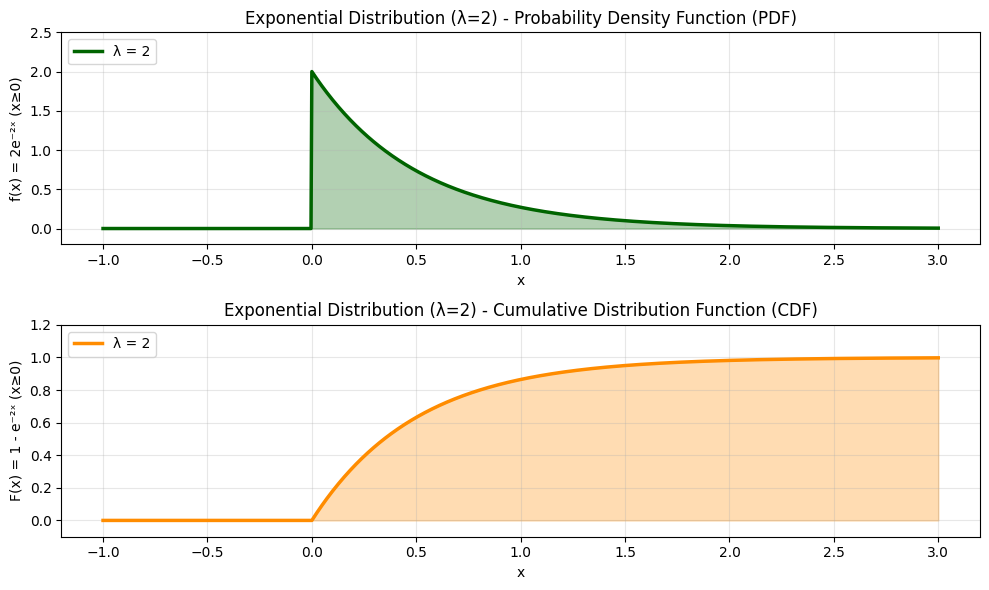

In [32]:
from scipy.stats import expon

def plot_exponential_pdf_cdf(lambda_val):
    lambda_val = 2
    x = np.linspace(-1, 3, 1001)
    
    scale_val = 1 / lambda_val  # scipy的expon分布参数化是「scale=1/λ」，loc=0（位置参数，无偏移）
    pdf = expon.pdf(x, loc=0, scale=scale_val)
    cdf = expon.cdf(x, loc=0, scale=scale_val)
    
    # pdf_manual = np.where(x >= 0, lambda_val * np.exp(-lambda_val * x), 0)
    # cdf_manual = np.where(x >= 0, 1 - np.exp(-lambda_val * x), 0)
    
    plt.figure(figsize=(10, 6))

    # PDF
    plt.subplot(2, 1, 1)
    plt.plot(x, pdf, color='darkgreen', linewidth=2.5, label=f'λ = {lambda_val}')
    plt.fill_between(x, pdf, alpha=0.3, color='darkgreen')  # 填充PDF下方区域
    plt.title(f'Exponential Distribution (λ={lambda_val}) - Probability Density Function (PDF)', fontsize=12)
    plt.xlabel('x', fontsize=10)
    plt.ylabel('f(x) = 2e⁻²ˣ (x≥0)', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.legend(loc = "upper left")  # 显示参数标签
    plt.ylim(-0.2, 2.5)  # 调整y轴范围，避免顶部过挤

    # CDF
    plt.subplot(2, 1, 2)
    plt.plot(x, cdf, color='darkorange', linewidth=2.5, label=f'λ = {lambda_val}')
    plt.fill_between(x, cdf, alpha=0.3, color='darkorange')  # 填充CDF下方区域
    plt.title(f'Exponential Distribution (λ={lambda_val}) - Cumulative Distribution Function (CDF)', fontsize=12)
    plt.xlabel('x', fontsize=10)
    plt.ylabel('F(x) = 1 - e⁻²ˣ (x≥0)', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.legend(loc = "upper left")  # 显示参数标签
    plt.ylim(-0.1, 1.2)  # 调整y轴范围

    plt.tight_layout()
    plt.show()

lambda_val = 2
plot_exponential_pdf_cdf(lambda_val=lambda_val)

---

#### 模拟指数随机变量 | Simulate an exponential random variable

The exponential CDF $F(x)$ is invertible. ($F(x)=1-e^{-\lambda x}, x \geqslant 0$)

$$
F^{-1}(u)=-\frac{\ln(1-u)}{\lambda}
$$

According to the inversion method, the random variable $F^{-1}(U)$:

$$
F^{-1}(U)=-\frac{\ln(1-U)}{\lambda}
$$

where $U$ is a uniform random variable, follows an exponential distribution with rate $\lambda$.

In practice, since $U$ and $1 - U$ have the same distribution, one can simply simulate an exponential distribution with the formula:

$$
-\frac{\ln(U)}{\lambda}
$$


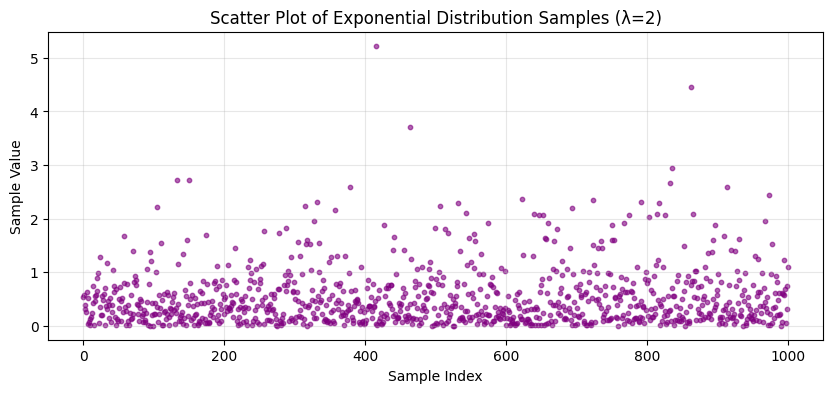

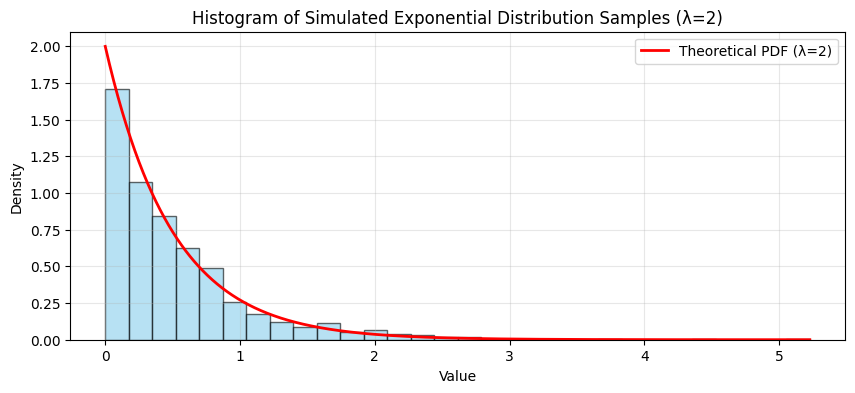

In [70]:
def generate_exponential(lambd, size=1):
    """
    生成指数分布随机数
    
    参数:
    lambd: 速率参数
    size: 需要生成的样本数量
    """
    u = np.random.uniform(0, 1, size)
    return -np.log(u) / lambd

def plot_simulated_exponential_x(samples):
    # 绘制样本的散点图
    plt.figure(figsize=(10, 4))
    plt.scatter(range(len(samples)), samples, color='purple', alpha=0.6, s=10)
    plt.title('Scatter Plot of Exponential Distribution Samples (λ=2)', fontsize=12)
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Value')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_simulated_exponential_y(samples):
    plt.figure(figsize=(10, 4))
    plt.hist(samples, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    
    # 绘制理论PDF曲线
    x = np.linspace(0, max(samples), 1001)
    pdf = 2 * np.exp(-2 * x)  # λ=2的指数分布PDF
    plt.plot(x, pdf, 'r-', lw=2, label='Theoretical PDF (λ=2)')
    
    plt.title('Histogram of Simulated Exponential Distribution Samples (λ=2)', fontsize=12)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_simulated_exponential(samples):
    plot_simulated_exponential_x(samples)
    plot_simulated_exponential_y(samples)

lambd, size = 2, 1001
samples = generate_exponential(lambd=lambd, size=size)
plot_simulated_exponential(samples)

---

#### Exponential simulation with SciPy

In [93]:
lmd = 2.0
print(expon.pdf([-0.25, 0.00, 0.25, 0.50, 0.75, 1.00], scale=1/lmd), "\n")
print(expon.cdf([-0.25, 0.00, 0.25, 0.50, 0.75, 1.00], scale=1/lmd), "\n")
print(expon.ppf([-0.25, 0.00, 0.25, 0.50, 0.75, 1.00], scale=1/lmd), "\n")
print(expon.rvs(size = [2, 2], scale=1/lmd))

[0.         2.         1.21306132 0.73575888 0.44626032 0.27067057] 

[0.         0.         0.39346934 0.63212056 0.77686984 0.86466472] 

[       nan 0.         0.14384104 0.34657359 0.69314718        inf] 

[[0.87085777 0.19739437]
 [0.16489054 2.47382197]]


---

### 2.4 帕累托分布 | Pareto Distribution

> 大事件发生的概率虽然小，但远比正态分布等传统分布所预测的要高。

The Pareto distribution with minimum value $x_m > 0$ and tail index $\alpha > 0$ (尾指数) is defined by the PDF:

$$
f(x)=\frac{\alpha x_m^\alpha}{x^{\alpha+1}}, \quad\quad (x \geqslant x_m)
$$

or equivalently by the CDF:

$$
F(x)=1-\left(\frac{x_m}{x}\right)^\alpha, \quad\quad (x \geqslant x_m)
$$

> 该分布最初由意大利经济学家维尔弗雷多·帕累托 提出，用于描述个人间的 财富分配。<br>
> 它还有许多其他应用，特别是在对 极端事件 进行建模方面，例如，金融市场中的极端价格波动或巨额亏损、保险业中的巨灾索赔、自然灾害，如特大降雨量或地震等级。

肥尾

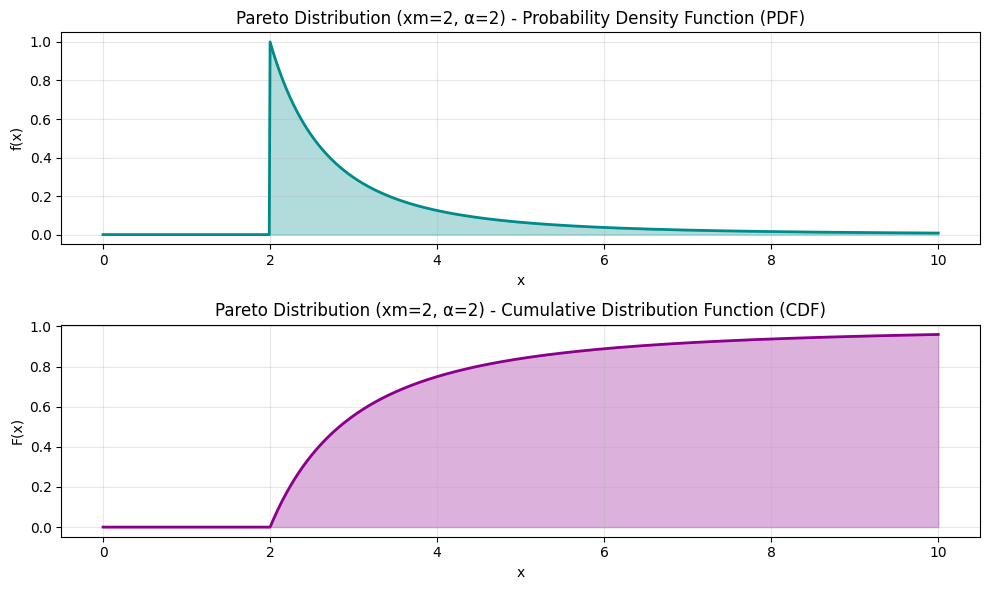

In [50]:
from scipy.stats import pareto

def plot_pareto_pdf_cdf(xm, alpha):
    x = np.linspace(0, 10, 1001)

    # b=α（尾指数），scale=xm（最小值），支持域x ≥ scale（即x ≥ xm）
    pdf = pareto.pdf(x, b=alpha, scale=xm)
    cdf = pareto.cdf(x, b=alpha, scale=xm)
    
    # pdf_manual = np.where(x >= xm, (alpha * (xm ** alpha)) / (x ** (alpha + 1)), 0)
    # cdf_manual = np.where(x >= xm, 1 - (xm / x) ** alpha, 0)

    plt.figure(figsize=(10, 6))

    # PDF
    plt.subplot(2, 1, 1)
    plt.plot(x, pdf, color='darkcyan', linewidth=2)
    plt.fill_between(x, pdf, alpha=0.3, color='darkcyan')  # 填充PDF下方区域
    plt.title(f'Pareto Distribution (xm={xm}, α={alpha}) - Probability Density Function (PDF)', fontsize=12)
    plt.xlabel('x', fontsize=10)
    plt.ylabel('f(x)', fontsize=10)
    plt.grid(True, alpha=0.3)

    # CDF
    plt.subplot(2, 1, 2)
    plt.plot(x, cdf, color='darkmagenta', linewidth=2)
    plt.fill_between(x, cdf, alpha=0.3, color='darkmagenta')  # 填充CDF下方区域
    plt.title(f'Pareto Distribution (xm={xm}, α={alpha}) - Cumulative Distribution Function (CDF)', fontsize=12)
    plt.xlabel('x', fontsize=10)
    plt.ylabel('F(x)', fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

xm, alpha = 2, 2
plot_pareto_pdf_cdf(xm=xm, alpha=alpha)


---

#### 模拟帕累托随机变量 | Simulate a Pareto random variable

The Pareto distribution is connected to the exponential distribution in the following way:
- If $X{\sim}\mathrm{Exp}(\alpha)$, then $Y=x_m\exp(X)$ is Pareto-distributed with minimum $x_m$ and tail index $\alpha$.

This connection provides a straightforward way to simulate a Pareto random variable: simulate an exponential random variable $X$, then return $x_m\exp(X)$ 

This is equivalent to applying the inversion method directly to the Pareto variable:

$$
F^{-1}(u)=\frac{x_m}{(1-u)^{\frac{1}{\alpha}}}
$$

therefore:

$$
F^{-1}(U)=\frac{x_m}{(1-U)^{1/\alpha}}
$$

The random variable $F^{-1}(U)$, where $U\sim\mathcal{U}[0, 1]$ is Pareto-distributed with minimum $x_m$ and tail index $\alpha$.

Once again, $U$ and $1 - U$ have the same distribution so,

$$
\frac{x_m}{(U)^{1/\alpha}}
$$
is also Pareto-distributed.




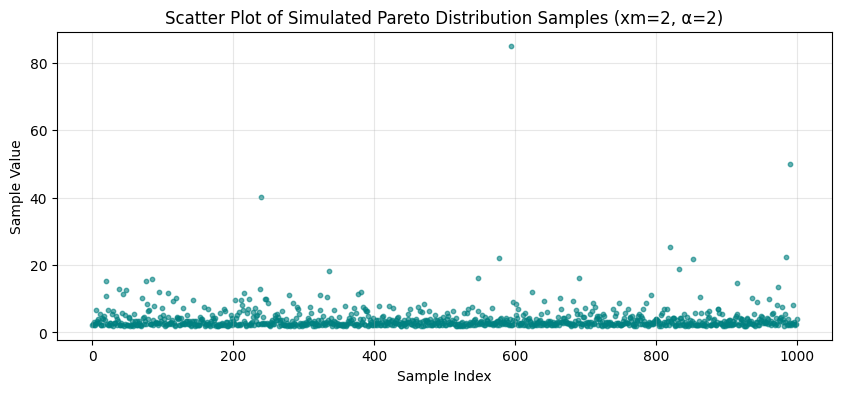

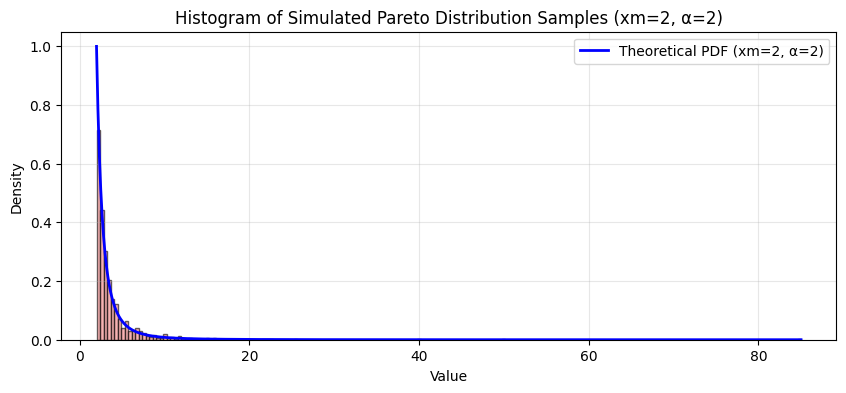

In [71]:
def generate_pareto(xm, alpha, size=1):
    """
    生成帕累托分布随机数
    
    参数:
    xm: 最小值参数
    alpha: 形状参数
    size: 需要生成的样本数量
    """
    u = np.random.uniform(0, 1, size)
    return xm / (u ** (1 / alpha))

def plot_simulated_pareto_x(samples):
    plt.figure(figsize=(10, 4))
    plt.scatter(range(len(samples)), samples, color='teal', alpha=0.6, s=10)
    plt.title(f'Scatter Plot of Simulated Pareto Distribution Samples (xm={xm}, α={alpha})', fontsize=12)
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Value')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_simulated_pareto_y(samples, xm, alpha):
    plt.figure(figsize=(10, 4))
    plt.hist(samples, bins=200, density=True, alpha=0.6, color='lightcoral', edgecolor='black')
    
    # 绘制理论PDF曲线
    x = np.linspace(xm, max(samples), 1001)
    pdf = (alpha * (xm ** alpha)) / (x ** (alpha + 1))  # 帕累托分布PDF
    plt.plot(x, pdf, 'b-', lw=2, label=f'Theoretical PDF (xm={xm}, α={alpha})')
    
    plt.title(f'Histogram of Simulated Pareto Distribution Samples (xm={xm}, α={alpha})', fontsize=12)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_simulated_pareto(samples, xm, alpha):
    plot_simulated_pareto_x(samples)
    plot_simulated_pareto_y(samples, xm, alpha)

xm, alpha, size = 2, 2, 1001
samples = generate_pareto(xm=xm, alpha=alpha, size=size)
plot_simulated_pareto(samples, xm, alpha)

---

#### Pareto simulation with SciPy


In [96]:
xm, alpha = 2.0, 2.0
print(pareto.pdf([1.0, 2.0, 3.00, 4.00], b=alpha, scale=xm), "\n")
print(pareto.cdf([2.0, 3.0, 4.00, 5.00], b=alpha, scale=xm), "\n")
print(pareto.ppf([0.00, 0.50, 0.90, 0.99], b=alpha, scale=xm), "\n")
print(pareto.rvs(size=[2,2], b=alpha, scale=xm))

[0.        1.        0.2962963 0.125    ] 

[0.         0.55555556 0.75       0.84      ] 

[ 2.          2.82842712  6.32455532 20.        ] 

[[2.68656619 2.04151965]
 [2.08612287 3.29127756]]


---

### 2.5 Box-Muller 方法 | The Box-Muller method

> Box-Muller方法就是专门为模拟（生成）高斯随机变量而设计的。

Let 
$$
U_1\sim\mathcal{U}[0,1] \\
U_2\sim\mathcal{U}[0,1]
$$

- $U_1, U_2$ are two independent simulations of standard uniform random variables.

Then

$$
N_1=\sqrt{-2\ln(U_1)}\sin(2\pi U_2) \\
N_2=\sqrt{-2\ln(U_1)}\cos(2\pi U_2)
$$

- $N_1, N_2$ are two independent simulations of standard Gaussian random variables.



---

### 2.6 高斯分布 | Gaussian Distribution

The standard Gaussian distribution (a.k.a. normal distribution) $\mathcal{N}(0, 1)$ with mean $0$ and variance $1$.

The PDF:

$$
\phi(x)=\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{x^2}{2}\right)
$$

More generally, the Gaussian distribution $\mathcal{N}(\mu, \sigma^2)$ with mean $\mu$ and variance $\sigma^2$.

The PDF:

$$
\phi_{\mu,\sigma}(x)=\frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
$$



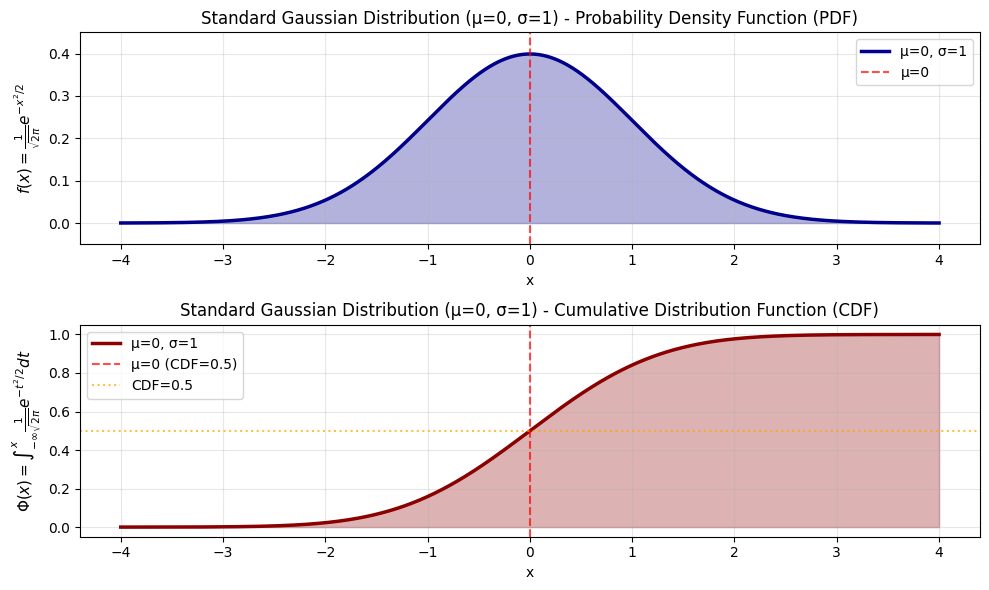

In [65]:
from scipy.stats import norm

def plot_normal_pdf_cdf(mu, sigma):
    mu, sigma = mu, sigma
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1001)
    
    # 标准高斯分布是norm的默认参数（loc=0, scale=1），可直接简写为norm.pdf(x)
    pdf = norm.pdf(x, loc=mu, scale=sigma)
    cdf = norm.cdf(x, loc=mu, scale=sigma)
    
    # pdf_mannual = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    
    plt.figure(figsize=(10, 6))

    # PDF（钟形曲线）
    plt.subplot(2, 1, 1)
    plt.plot(x, pdf, color='darkblue', linewidth=2.5, label=f'μ={mu}, σ={sigma}')
    plt.fill_between(x, pdf, alpha=0.3, color='darkblue')  # 填充PDF下方区域
    plt.axvline(x=mu, color='red', linestyle='--', alpha=0.7, label=f'μ={mu}')
    plt.title(f'Standard Gaussian Distribution (μ={mu}, σ={sigma}) - Probability Density Function (PDF)', fontsize=12)
    plt.xlabel('x', fontsize=10)
    plt.ylabel(r'$f(x) = \frac{1}{\sqrt{2\pi}} e^{-x^2/2}$', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(-0.05, 0.45)

    # CDF（S形曲线）
    plt.subplot(2, 1, 2)
    plt.plot(x, cdf, color='darkred', linewidth=2.5, label=f'μ={mu}, σ={sigma}')
    plt.fill_between(x, cdf, alpha=0.3, color='darkred')  # 填充CDF下方区域
    plt.axvline(x=mu, color='red', linestyle='--', alpha=0.7, label=f'μ={mu} (CDF=0.5)')
    plt.axhline(y=0.5, color='orange', linestyle=':', alpha=0.7, label='CDF=0.5')
    plt.title(f'Standard Gaussian Distribution (μ={mu}, σ={sigma}) - Cumulative Distribution Function (CDF)', fontsize=12)
    plt.xlabel('x', fontsize=10)
    plt.ylabel(r'$\Phi(x) = \int_{-\infty}^x \frac{1}{\sqrt{2\pi}} e^{-t^2/2} dt$', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(-0.05, 1.05)

    plt.tight_layout()
    plt.show()
    
mu, sigma = 0, 1
plot_normal_pdf_cdf(mu=mu, sigma=sigma)

---

#### 模拟高斯随机变量 | Simulate a Gaussian random variable


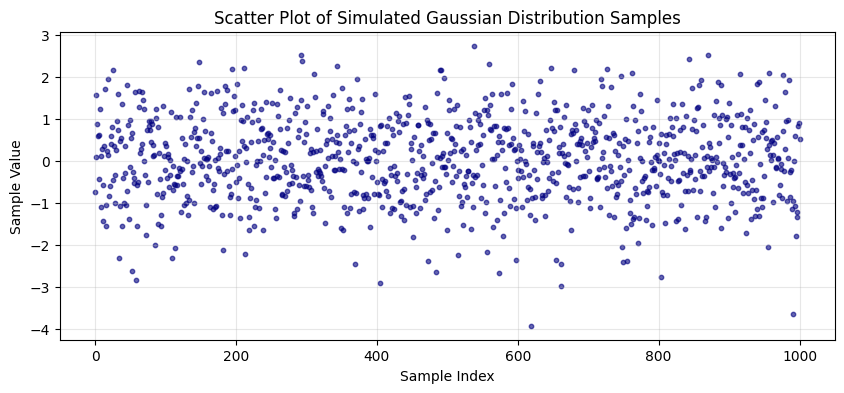

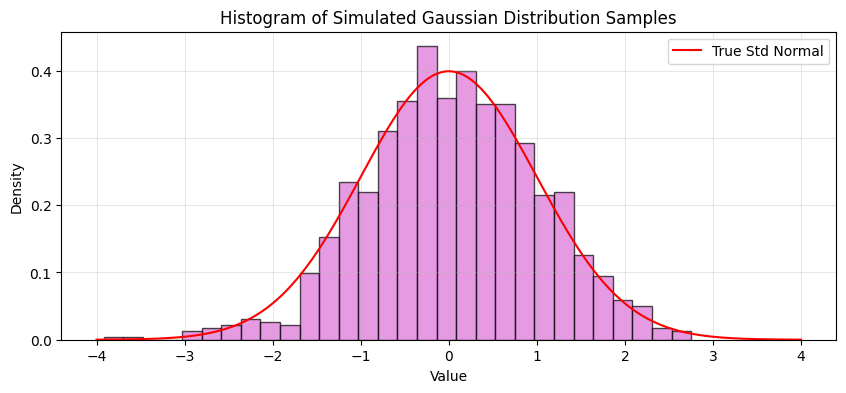

In [80]:
def box_muller(size):
    """
    生成标准正态分布随机数（Box-Muller变换）
    
    参数：
    size: 需要生成的样本数量
    """
    # u1 = np.random.rand(n)
    # u2 = np.random.rand(n)
    u1 = np.random.uniform(0, 1, size)
    u2 = np.random.uniform(0, 1, size)
    
    z0 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    z1 = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)
    
    return z0, z1

def plot_simulated_gaussian_x(samples):
    plt.figure(figsize=(10, 4))
    plt.scatter(range(len(samples)), samples, color='navy', alpha=0.6, s=10)
    plt.title('Scatter Plot of Simulated Gaussian Distribution Samples', fontsize=12)
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Value')
    plt.grid(True, alpha=0.3)
    plt.show()
    
def plot_simulated_gaussian_y(samples):
    plt.figure(figsize=(10, 4))
    plt.hist(samples, bins=30, density=True, alpha=0.7, color='orchid', edgecolor='black')
    
    # 绘制理论PDF曲线
    x = np.linspace(-4, 4, 1001)
    plt.plot(x, (1/np.sqrt(2*np.pi)) * np.exp(-x**2/2), 'r-', label='True Std Normal')
    
    plt.title('Histogram of Simulated Gaussian Distribution Samples', fontsize=12)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_simulated_gaussian(samples):
    plot_simulated_gaussian_x(samples)
    plot_simulated_gaussian_y(samples)

size = 1001
samples, _ = box_muller(size)
plot_simulated_gaussian(samples)

---

#### Gaussian simulation with SciPy

In [97]:
mu, sigma = 2.0, 4.0
print(norm.pdf([-2.00, 2.00, 6.00, 10.00], loc=mu, scale=sigma), "\n")
print(norm.cdf([-2.00, 2.00, 6.00, 10.00], loc=mu, scale=sigma), "\n")
print(norm.ppf([0.01, 0.50, 0.90, 0.99], loc=mu, scale=sigma), "\n")
print(norm.rvs(size=[2,2], loc=mu, scale=sigma))

[0.06049268 0.09973557 0.06049268 0.01349774] 

[0.15865525 0.5        0.84134475 0.97724987] 

[-7.3053915   2.          7.12620626 11.3053915 ] 

[[-2.69681447 -1.77711303]
 [-3.43238478  1.94633357]]


---

### 2.7 对数正态分布 | Lognormal distribution

If $X\sim\mathcal{N}(\mu,\sigma)$ is a normal random variable, then $Y=\exp(X)\sim\mathrm{LogNorm}(\mu,\sigma)$ follows a **lognormal distribution**.

PDF:

$$
f(x)=\frac{1}{x\sigma\sqrt{2\pi}}\mathrm{exp}\left(-\frac{(\ln(x)-\mu)^2}{2\sigma^2}\right)
$$

CDF:

$$
F(x)=\Phi\left(\frac{\ln(x)-\mu}{\sigma}\right)
$$

- $\Phi$ is the standard normal CDF.



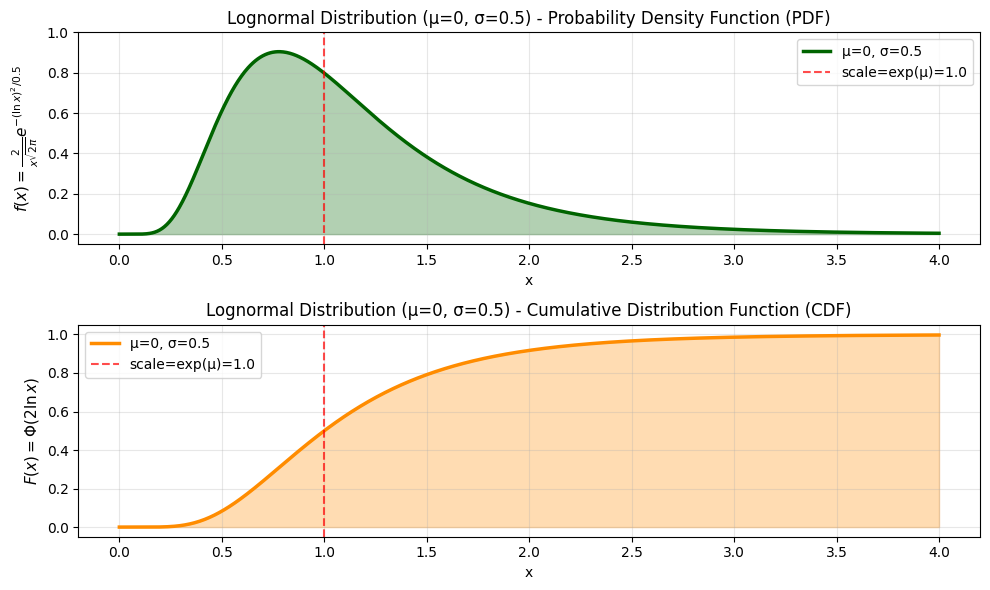

In [82]:
from scipy.stats import lognorm

def plot_lognormal_pdf_cdf(mu, sigma):
    mu, sigma = mu, sigma
    x = np.linspace(0, 4, 1001)
    
    # s=σ，scale=exp(μ)
    scale_val = np.exp(mu)
    pdf = lognorm.pdf(x, s=sigma, scale=scale_val)
    cdf = lognorm.cdf(x, s=sigma, scale=scale_val)
    
    plt.figure(figsize=(10, 6))  # 画布大小

    # PDF（右偏曲线，x>0有效）
    plt.subplot(2, 1, 1)
    plt.plot(x, pdf, color='darkgreen', linewidth=2.5, label=f'μ={mu}, σ={sigma}')
    plt.fill_between(x, pdf, alpha=0.3, color='darkgreen')  # 填充PDF下方区域
    plt.axvline(x=scale_val, color='red', linestyle='--', alpha=0.7, label=f'scale=exp(μ)={scale_val}')
    plt.title(f'Lognormal Distribution (μ={mu}, σ={sigma}) - Probability Density Function (PDF)', fontsize=12)
    plt.xlabel('x', fontsize=10)
    plt.ylabel(r'$f(x) = \frac{2}{x\sqrt{2\pi}} e^{-(\ln x)^2 / 0.5}$', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(-0.05, 1.0)

    # CDF（S形曲线，x>0递增）
    plt.subplot(2, 1, 2)
    plt.plot(x, cdf, color='darkorange', linewidth=2.5, label=f'μ={mu}, σ={sigma}')
    plt.fill_between(x, cdf, alpha=0.3, color='darkorange')  # 填充CDF下方区域
    plt.axvline(x=scale_val, color='red', linestyle='--', alpha=0.7, label=f'scale=exp(μ)={scale_val}')
    plt.title(f'Lognormal Distribution (μ={mu}, σ={sigma}) - Cumulative Distribution Function (CDF)', fontsize=12)
    plt.xlabel('x', fontsize=10)
    plt.ylabel(r'$F(x) = \Phi(2\ln x)$', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(-0.05, 1.05)

    plt.tight_layout()
    plt.show()

mu, sigma = 0, 0.5
plot_lognormal_pdf_cdf(mu=mu, sigma=sigma)  

---

#### 模拟对数正态随机变量 | Simulate a Lognormal random variable

Simulate a standard Gaussian variable $N\sim\mathcal{N}(0,1)$  using one of the algorithms described previously.

Then $\exp(\mu+\sigma N)$ is a simulation of a lognormal variable with parameters $\mu$ and $\sigma$

> 在金融中，对数正态分布用于低频（月或更高）的资产价格建模。<br>
> 它也为许多其他应用提供了良好的拟合，例如城市人口规模（吉布拉定律）、国际象棋游戏的时长或互联网讨论论坛中发布的评论长度。


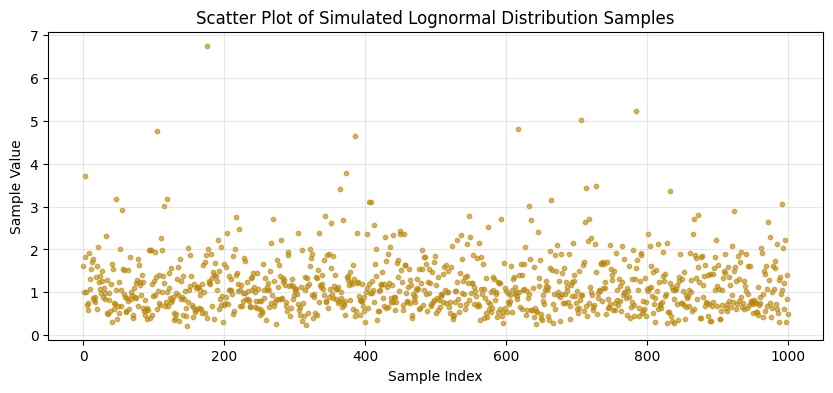

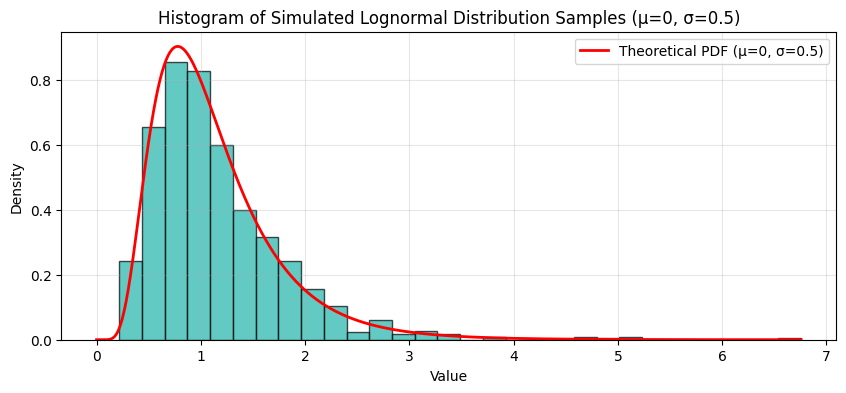

In [89]:
def generate_lognormal(mu, sigma, size=1):
    """
    生成对数正态分布随机数
    
    参数:
    mu: 对数均值参数
    sigma: 对数标准差参数
    size: 需要生成的样本数量
    """
    # 先生成标准正态分布随机数
    # z = np.random.normal(0, 1, size)
    u1 = np.random.uniform(0, 1, size)
    u2 = np.random.uniform(0, 1, size)
    
    z = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    
    # 再通过对数正态变换得到对数正态分布随机数
    return np.exp(mu + sigma * z)

def plot_simulated_lognormal_x(samples):
    plt.figure(figsize=(10, 4))
    plt.scatter(range(len(samples)), samples, color='darkgoldenrod', alpha=0.6, s=10)
    plt.title('Scatter Plot of Simulated Lognormal Distribution Samples', fontsize=12)
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Value')
    plt.grid(True, alpha=0.3)
    plt.show()
    
def plot_simulated_lognormal_y(samples, mu, sigma):
    plt.figure(figsize=(10, 4))
    plt.hist(samples, bins=30, density=True, alpha=0.7, color='lightseagreen', edgecolor='black')
    
    # 绘制理论PDF曲线
    x = np.linspace(0, max(samples), 1001)
    scale_val = np.exp(mu)
    pdf = lognorm.pdf(x, s=sigma, scale=scale_val)  # 对数正态分布PDF
    plt.plot(x, pdf, 'r-', lw=2, label=f'Theoretical PDF (μ={mu}, σ={sigma})')
    
    plt.title(f'Histogram of Simulated Lognormal Distribution Samples (μ={mu}, σ={sigma})', fontsize=12)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
def plot_simulated_lognormal(samples, mu, sigma):
    plot_simulated_lognormal_x(samples)
    plot_simulated_lognormal_y(samples, mu, sigma)
    
mu, sigma, size = 0, 0.5, 1001
samples = generate_lognormal(mu=mu, sigma=sigma, size=size)
plot_simulated_lognormal(samples, mu, sigma)

---

#### Lognormal simulation with SciPy

In [98]:
mu, s = np.exp(2.0), 4.0
print(lognorm.pdf([0.0, mu, mu+s, mu+2*s], s=s, scale=mu), "\n")
print(lognorm.cdf([0.0, mu, mu+10*s, mu+100*s], s=s, scale=mu), "\n")
print(lognorm.ppf([0.50, 0.90, 0.99], s=s, scale=mu), "\n")
print(lognorm.rvs(size=[2,3], s=s, scale=mu))

[0.         0.01349774 0.00870606 0.00637284] 

[0.         0.5        0.67889026 0.84193496] 

[7.38905610e+00 1.24414803e+03 8.12585639e+04] 

[[1.29830969e-03 2.23463019e-01 8.63853450e+00]
 [9.07305591e+00 1.70947923e+02 2.86700786e+02]]


---

## 3.肥尾分布 | Heavy-tailed distributions


#### 3.1 典型事实 | Stylized facts

Many empirical studies have identified a set of common features among financial data that are known as **stylized facts**.

1. Fat tails，肥尾
    - The unconditional distribution of returns has fatter tails than that expected from a normal distribution. 
    - This means that, if we use the normal distribution to model financial returns, we will underestimate the number and magnitude of crashes and booms.

2. Asymmetry，不对称性
    - The unconditional distribution is negatively skewed, suggesting that extreme negative returns are more frequent than extreme positive returns. 
    - The asymmetry and fat-tail phenomena persist even after adjusting for conditional heteroskedasticity (or changing volatility), meaning that the conditional distribution is also non-normal.

3. Aggregated normality，聚合正态性
    -  as the frequency of the returns lengthens, the return distribution gets closer to the normal distribution.

4. Absence of serial correlation，缺乏序列自相关
    - Returns generally do not display significant serial correlation (a.k.a. autocorrelation), except at high frequency. 
    - (These can be computed in Python with the Pandas function plotting.autocorrelation_plot).

5. Volatility clustering，波动率聚集
    - The volatility of returns is serially correlated, suggesting that a large (positive or negative) return tends to be followed by another large (positive or negative) return. 
    - Among the proxies for volatility, absolute returns appear to be the most strongly serially correlated.

6. Time-varying cross-correlation，时变的交叉相关性
    - Correlation between asset returns tends to increase during high volatility periods, in particular during crashes.





---

#### 3.2 Student's t-distribution

In [99]:
from scipy.stats import t

nu = 3
print(t.pdf([-4.0, 0.0, 2.0, 4.0], df=nu), "\n")
print(t.cdf([-4.0, 0.0, 2.0, 4.0], df=nu), "\n")
print(t.ppf([0.01, 0.50, 0.90, 0.99], df=nu), "\n")
print(t.rvs(size=[2,2], df=nu))

[0.00916336 0.3675526  0.06750966 0.00916336] 

[0.01400423 0.5        0.93033702 0.98599577] 

[-4.54070286e+00  7.20375989e-17  1.63774435e+00  4.54070286e+00] 

[[ 2.39161856 -0.40368509]
 [ 0.33819422  0.16407051]]


---

#### 3.3 Cauchy distribution


In [115]:
from scipy.stats import cauchy

print(cauchy.pdf([-4, 0, 2, 4]), "\n")
print(cauchy.cdf([-4, 0, 2, 4]), "\n")
print(cauchy.ppf([0.10, 0.50, 0.99]), "\n")
print(cauchy.rvs(size=[2,2]))

[0.01872411 0.31830989 0.06366198 0.01872411] 

[0.07797913 0.5        0.85241638 0.92202087] 

[-3.07768354  0.         31.82051595] 

[[ 0.50351386  2.06832235]
 [-1.1474493   0.10531697]]
